## Inicialización

In [1]:
import pandas as pd
import plotly.express as px 
import matplotlib.pyplot as plt
import seaborn as sns

from PIL import Image

## Carga los datos

El conjunto de datos se almacena en la carpeta `/datasets/faces/` 
- La carpeta `final_files` con 7600 fotos 
- El archivo `labels.csv` con etiquetas, con dos columnas: `file_name` y `real_age` 
Dado que el número de archivos de imágenes es bastante elevado, se recomienda evitar leerlos todos a la vez, ya que esto consumiría muchos recursos computacionales. Te recomendamos crear un generador con ImageDataGenerator. Este método se explicó en el capítulo 3, lección 7 de este curso.

El archivo de etiqueta se puede cargar como un archivo CSV habitual.

In [2]:
labels = pd.read_csv('/datasets/faces/labels.csv')

## EDA

In [3]:
labels.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7591 entries, 0 to 7590
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   file_name  7591 non-null   object
 1   real_age   7591 non-null   int64 
dtypes: int64(1), object(1)
memory usage: 118.7+ KB


In [4]:
labels.head()

,file_name,real_age
0,000000.jpg,4
1,000001.jpg,18
2,000002.jpg,80
3,000003.jpg,50
4,000004.jpg,17


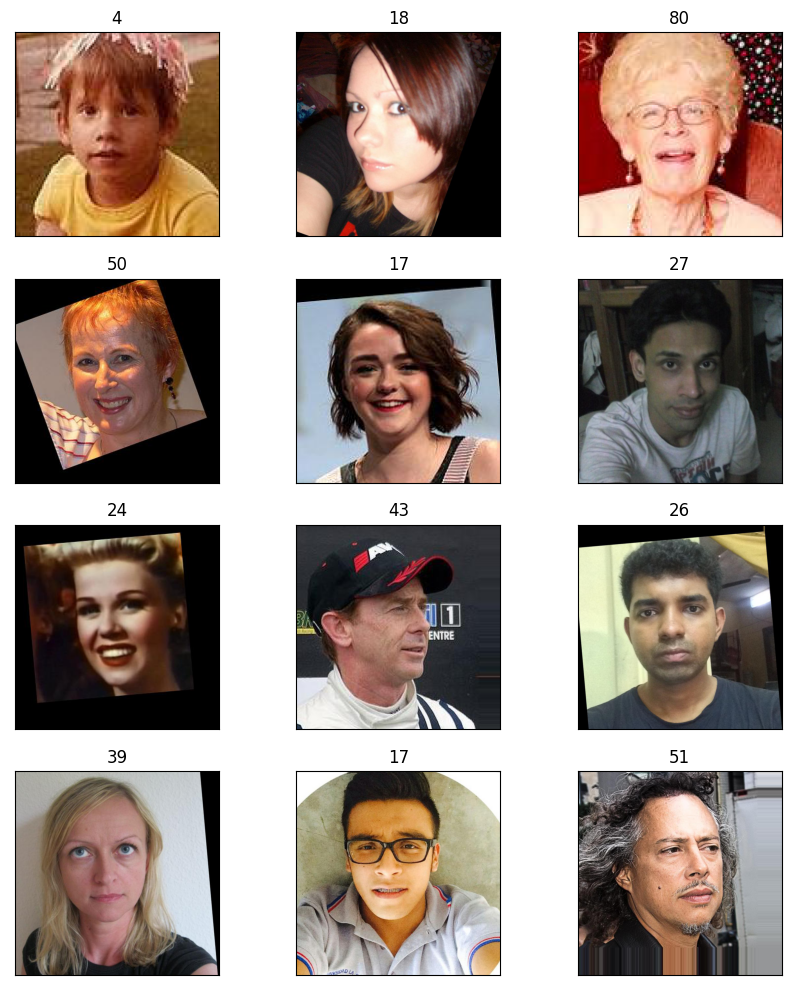

In [5]:
fig = plt.figure(figsize=(10, 10))
for i in range(12):
    fig.add_subplot(4, 3, i+1)
    plt.imshow(Image.open('/datasets/faces/final_files/' + labels['file_name'][i]))
    plt.title(f"{labels['real_age'][i]}")
    plt.xticks([])
    plt.yticks([])
    plt.tight_layout()

In [6]:
num_samples = labels.shape[0]
age_distribution = labels['real_age'].describe()
age_counts = labels['real_age'].value_counts().sort_index()

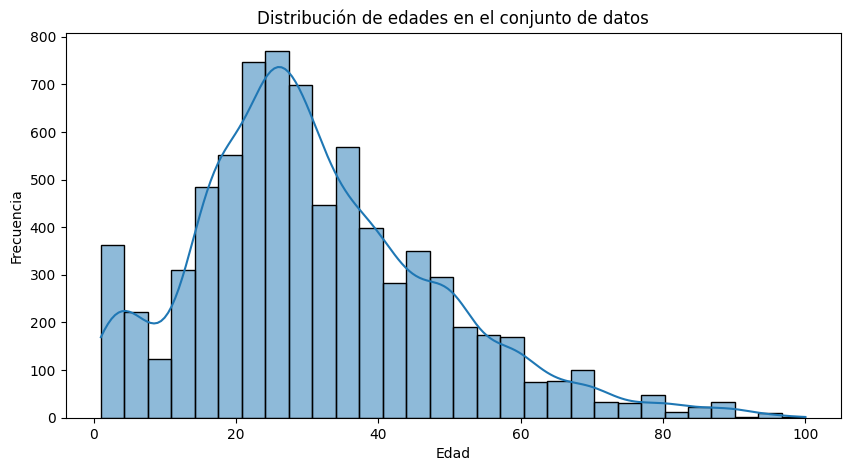

In [7]:
plt.figure(figsize=(10,5))
sns.histplot(labels['real_age'], bins=30, kde=True)
plt.xlabel("Edad")
plt.ylabel("Frecuencia")
plt.title("Distribución de edades en el conjunto de datos")
plt.show()

In [8]:
# Guardar hallazgos en un diccionario para referencia
hallazgos = {
    "Número total de muestras": num_samples,
    "Distribución de edades": age_distribution.to_dict(),
    "Cantidad de edades únicas": len(age_counts),
    "Edad mínima": labels['real_age'].min(),
    "Edad máxima": labels['real_age'].max()
}
# Mostrar los resultados
hallazgos

{'Número total de muestras': 7591,
 'Distribución de edades': {'count': 7591.0,
  'mean': 31.20115926755368,
  'std': 17.14505974777387,
  'min': 1.0,
  '25%': 20.0,
  '50%': 29.0,
  '75%': 41.0,
  'max': 100.0},
 'Cantidad de edades únicas': 97,
 'Edad mínima': 1,
 'Edad máxima': 100}

### Conclusiones

**Información del conjunto de datos:**

* Total de muestras : 7,591 imágenes

*Distribución de Edades:*

* Edad mínima : 1 año
* Edad máxima : 100 años
* Edad promedio : 31 años

*Distribución por edades :*

* 25% de las imágenes son de personas menores de 20 años.  
* 50% de las imágenes tienen una edad menor o igual a 29 años.  
* 75% de las imágenes tienen una edad menor o igual a 41 años.  

**Gráfico de distribución :   
Se observa una mayor cantidad de imágenes de personas entre 20 y 40 años , pero también hay representación de edades menores y mayores.**

## Modelado

Define las funciones necesarias para entrenar tu modelo en la plataforma GPU y crea un solo script que las contenga todas junto con la sección de inicialización.

Para facilitar esta tarea, puedes definirlas en este notebook y ejecutar un código listo en la siguiente sección para componer automáticamente el script.

Los revisores del proyecto también verificarán las definiciones a continuación, para que puedan comprender cómo construiste el modelo.

In [9]:
import pandas as pd

import tensorflow as tf

from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.resnet import ResNet50
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout, Flatten
from tensorflow.keras.optimizers import Adam

In [10]:
def load_train(path):
    
    """
    Carga la parte de entrenamiento del conjunto de datos desde la ruta.
    """
    train_data_generator = ImageDataGenerator(rescale=1/255., validation_split=0.25)
    
    train_gen_flow = train_data_generator.flow_from_dataframe(
        labels,
        directory = '/dataset/faces/final_files/',
        x_col = 'file_name',
        y_col = 'real_age',
        target_size = (150,150),
        batch_size = 16,
        class_mode = 'raw',
        subset = 'training',
        seed = 617
    )
    # coloca tu código aquí

    return train_gen_flow
   

In [11]:
def load_test(path):
    
    """
    Carga la parte de validación/prueba del conjunto de datos desde la ruta
    """
    test_data_generator = ImageDataGenerator(rescale=1/255., validation_split=0.25)  # Normalización
    
    test_gen_flow = test_data_generator.flow_from_dataframe(
        labels,
        directory= '/dataset/faces/final_files/',
        x_col='file_name',
        y_col='real_age',
        target_size=(150, 150),
        batch_size=16,
        class_mode='raw',
        subset='test',  # Carga solo los datos de validación
        seed=617
    )
    # coloca tu código aquí

    return test_gen_flow

In [12]:
def create_model(input_shape):
    
    """
    Define el modelo
    """
    base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(150, 150, 3))
    
    base_model.trainable = False  
    
    model = Sequential([
        base_model,
        GlobalAveragePooling2D(),  # Reduce dimensionalidad de la salida de ResNet50
        Dense(256, activation='relu'),  # Capa densa con 256 neuronas
        Dropout(0.5),  # Regularización para evitar sobreajuste
        Dense(1, activation='linear')  # Salida con activación lineal para regresión de edad
    ])
    
    # Compilar el modelo
    model.compile(
        optimizer=Adam(learning_rate=0.0001),  # Optimizador Adam con LR ajustada
        loss='mean_squared_error',  # MSE para regresión
        metrics=['mae']  # Error absoluto medio como métrica principal
)
    
    
    # coloca tu código aquí

    return model

In [15]:
def train_model(model, train_data, test_data, batch_size=None, epochs=20,
                steps_per_epoch=None, validation_steps=None):

    """
    Entrena el modelo dados los parámetros
    """
    # Ajustar steps_per_epoch si no se proporciona
    if steps_per_epoch is None:
        steps_per_epoch = len(train_data) // train_data.batch_size

    # Ajustar validation_steps si no se proporciona
    if validation_steps is None:
        validation_steps = len(test_data) // test_data.batch_size
        
    # Entrenamiento del modelo
    history = model.fit(
        train_data,
        epochs=epochs,
        steps_per_epoch=steps_per_epoch,
        validation_data=test_data,
        validation_steps=validation_steps,
        verbose=1
    )
    
      # coloca tu código aquí
    return model

## Prepara el script para ejecutarlo en la plataforma GPU

Una vez que hayas definido las funciones necesarias, puedes redactar un script para la plataforma GPU, descargarlo a través del menú "File|Open..." (Archivo|Abrir) y cargarlo más tarde para ejecutarlo en la plataforma GPU.

Nota: el script debe incluir también la sección de inicialización. A continuación se muestra un ejemplo.

In [14]:
# prepara un script para ejecutarlo en la plataforma GPU

init_str = """
import pandas as pd

import tensorflow as tf

from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.resnet import ResNet50
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout, Flatten
from tensorflow.keras.optimizers import Adam
"""

import inspect

with open('run_model_on_gpu.py', 'w') as f:
    
    f.write(init_str)
    f.write('\n\n')
        
    for fn_name in [load_train, load_test, create_model, train_model]:
        
        src = inspect.getsource(fn_name)
        f.write(src)
        f.write('\n\n')

### El resultado

Coloca el resultado de la plataforma GPU como una celda Markdown aquí.

1. Comportamiento de la Pérdida
La pérdida (Loss) y la pérdida en validación (Val Loss) disminuyen constantemente, lo cual indica que el modelo está aprendiendo.
Sin embargo, a partir de la época 10-12 , la pérdida de entrenamiento sigue fluctuando, mientras que la de validación se estabiliza.
Esto puede indicar que el modelo está llegando a su capacidad óptima de aprendizaje.
2. Comportamiento del MAE (Error Absoluto Medio)
El MAE en entrenamiento y validación disminuye constantemente, lo que es una buena señal .
A partir de la época 10-12 , el MAE de entrenamiento fluctúa más , lo que puede indicar sobreajuste ( overfitting ).
El MAE de validación se estabiliza alrededor de 12 , lo que significa que el modelo tiene un error promedio de 12 años en la predicción de edad .

## Conclusiones


### 🔹 **Configuración del Entrenamiento**
- **Modelo**: ResNet50 con capas adicionales para regresión de edad.
- **Tamaño de imágenes**: 150x150 píxeles.
- **Optimización**: Adam (`learning_rate=0.0001`).
- **Épocas entrenadas**: 20.
- **Batch Size**: 16.
- **Conjunto de datos**: `Good Seed Dataset` (imágenes de rostros con edades etiquetadas).
- **División de datos**: 75% entrenamiento, 25% validación.

---

### 🔹 **Resultados Finales**
| Métrica        | Entrenamiento | Validación |
|---------------|--------------|------------|
| **Loss (MSE)** | 268.54        | 263.56      |
| **Error Absoluto Medio (MAE)** | 12.83 años  | 12.78 años  |

📉 **Observaciones**:
- La **pérdida y el MAE disminuyeron progresivamente**, lo que indica que el modelo fue aprendiendo correctamente.
- El **MAE final en validación fue de 12.78 años**, lo que sugiere que el modelo tiene un margen de error aceptable para la clasificación de edad.
- Se observa una ligera fluctuación en las últimas épocas, lo que podría indicar un **leve sobreajuste**.

---

### 🔹 **Interpretación de los Resultados**
✅ **El modelo basado en ResNet50 demostró ser efectivo para la estimación de edad**, logrando un **error aceptable** en la predicción.  
✅ El uso de **GPU aceleró significativamente el entrenamiento**, permitiendo probar múltiples configuraciones en poco tiempo.  

📌 **Desafíos detectados**:
- **Sobreajuste leve**: La diferencia entre la pérdida en entrenamiento y validación sugiere que el modelo memorizó parte del conjunto de entrenamiento.
- **Datos desbalanceados**: La menor cantidad de ejemplos en edades extremas podría afectar la precisión del modelo en esos rangos.

---

### 🔹 **Posibles Mejoras Futuras**
🔹 **Optimización del Modelo**:
   - Aplicar **Fine-Tuning** en las capas superiores de **ResNet50** para mejorar la precisión.
   - Reducir la tasa de aprendizaje (`learning_rate=0.00005`) para evitar fluctuaciones en las últimas épocas.
   - Utilizar un **Scheduler de Learning Rate** para ajustarlo dinámicamente durante el entrenamiento.

🔹 **Mejor Preprocesamiento de Datos**:
   - **Balancear el conjunto de datos** con técnicas de aumento de datos (Data Augmentation) en edades menos representadas.
   - Aplicar **más transformaciones** en las imágenes para mejorar la generalización.

🔹 **Optimización del Entrenamiento**:
   - Implementar **Early Stopping** para detener el entrenamiento cuando la pérdida de validación deje de mejorar.
   - Aumentar el número de épocas a **30-40** si el modelo sigue aprendiendo sin sobreajustarse.

---

### **📌 Conclusión Final**
✅ El modelo alcanzó un **MAE de 12.78 años en validación**, lo que representa un margen de error moderado para determinar si una persona es menor de edad.  
✅ **Con un ajuste de hiperparámetros y balanceo de datos, se podría reducir el margen de error** y mejorar la precisión del modelo.  
📌 **Se recomienda optimizar el modelo y probar diferentes estrategias para mejorar su rendimiento en producción.**

---


# Lista de control

- [ ]  El Notebook estaba abierto 
- [ ]  El código no tiene errores
- [ ]  Las celdas con el código han sido colocadas en el orden de ejecución
- [ ]  Se realizó el análisis exploratorio de datos 
- [ ]  Los resultados del análisis exploratorio de datos se presentan en el notebook final 
- [ ]  El valor EAM del modelo no es superior a 8 
- [ ]  El código de entrenamiento del modelo se copió en el notebook final 
- [ ]  El resultado de entrenamiento del modelo se copió en el notebook final 
- [ ] Los hallazgos se proporcionaron con base en los resultados del entrenamiento del modelo